In [10]:
# Import libraries
import numpy as np
import os , csv
from os import listdir
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.interpolate import interp1d
from sklearn.decomposition import TruncatedSVD
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
import DataPreprocessing as spike_process



In [11]:
# Load desired data from 1 session 1 animal
# Note that there are 340 trials in 1 session
# (For more info https://github.com/nsteinme/steinmetz-et-al-2019/wiki/data-files)

data_path = '/Users/ChiaXinWei/Documents/Connected_lizards/Steinmetz/Richards_2017-10-31'

trials_intervals = np.load(data_path+'/'+'trials.intervals.npy') # in seconds
spike_times = np.load(data_path+'/'+'spikes.times.npy') * 1000 # Unbinned spike times in ms
trials_gocue_times = np.load(data_path+'/'+'trials.goCue_times.npy') 
trials_response_choice = np.load(data_path+'/'+'trials.response_choice.npy') # -1 left, 1, right, 0 no response
spontaneous_intervals = np.load(data_path+'/'+'spontaneous.intervals.npy')
trials_response_time = np.load(data_path+'/'+'trials.response_times.npy')
spike_clusters = np.load(data_path+'/'+'spikes.clusters.npy')
site_positions = np.load(data_path+'/'+'channels.sitePositions.npy')
clusters_depths = np.load(data_path+'/'+'clusters.depths.npy')
clusters_annotation = np.load(data_path+'/'+'clusters._phy_annotation.npy')
channel_sites = np.load(data_path+'/'+'channels.site.npy')
channels_brainlocation = pd.read_csv(data_path+'/'+'channels.brainLocation.tsv', sep='\t')
clusters_probes = np.load(data_path+'/'+'clusters.probes.npy')
channels_probe = np.load(data_path+'/'+'channels.probe.npy')
trials_visual_time = np.load(data_path+'/'+'trials.visualStim_times.npy')
trial_feedback_time = np.load(data_path+'/'+'trials.feedback_times.npy')
trial_feedback_type = np.load(data_path+'/'+'trials.feedbackType.npy')
trial_response_time = np.load(data_path+'/'+'trials.response_times.npy')

visual_times = trials_visual_time
# Behaviour data

wheel_movement = np.load(data_path+'/'+'wheelMoves.type.npy')
wheel_intervals = np.load(data_path+'/'+'wheelMoves.intervals.npy')




## Initialising spikes and behaviour data

In [143]:
dT = 2.5
T0 = .5
bin_size = 100
dt = bin_size/1000

mid_brain_circuits=['SCs','SCm','MRN','APN','PAG','ZI']
frontal_circuits=['MOs','PL','ILA','ORB','MOp','SSp']

# Get neural activity data
good_cells, brain_regions ,br = spike_process.get_good_cells(data_path) # Get brain regions
spike_time_binned, spike_time_cells, cell_spikes_max = spike_process.bin_spikes(spike_times,spike_clusters,clusters_annotation,bin_size)
# spike_time_binned_trial, spike_time_binned_trial_response = spike_process.sort_cells_trials(spike_time_binned, spike_time_cells, trials_intervals,trials_visual_time, epoch_duration = 2000,10)
spike_time_binned_trial, pre_stim_spike_time_binned_trial, post_stim_spike_time_binned_trial, post_go_cue_spike_time_binned_trial, post_go_cue_spike_time_binned_trial = spike_process.sort_cells_behaviour_trials(spike_time_binned,spike_time_cells,trials_intervals, trials_visual_time,trials_gocue_times,trial_feedback_time, bin_size)

# Sort cells into left, right and no_response trial types
# Input behaviour phase that you want to analyse
input_spike_behaviour_period =  post_stim_spike_time_binned_trial
left_spike_time_response, right_spike_time_response, no_response_spike_time_response = spike_process.sort_cells_trial_types(input_spike_behaviour_period,trials_intervals,spike_time_cells,trials_response_choice)

# Midbrain cells
midbrain_left_spike = spike_process.sort_cells_brain_regions(left_spike_time_response, brain_regions, clusters_annotation, mid_brain_circuits)
midbrain_right_spike = spike_process.sort_cells_brain_regions(right_spike_time_response, brain_regions, clusters_annotation, mid_brain_circuits)
midbrain_no_response_spike = spike_process.sort_cells_brain_regions(no_response_spike_time_response, brain_regions, clusters_annotation, mid_brain_circuits)
midbrain_concat_left_spike_times = spike_process.concat_trials_2_timeseries(midbrain_left_spike)
midbrain_concat_right_spike_times = spike_process.concat_trials_2_timeseries(midbrain_right_spike)
midbrain_concat_no_response_spike_times = spike_process.concat_trials_2_timeseries(midbrain_no_response_spike)

# Forebrain cells
forebrain_left_spike = spike_process.sort_cells_brain_regions(left_spike_time_response, brain_regions, clusters_annotation, frontal_circuits)
forebrain_right_spike = spike_process.sort_cells_brain_regions(right_spike_time_response, brain_regions, clusters_annotation, frontal_circuits)
forebrain_no_response_spike = spike_process.sort_cells_brain_regions(no_response_spike_time_response, brain_regions, clusters_annotation, frontal_circuits)
forebrain_concat_left_spike_times = spike_process.concat_trials_2_timeseries(forebrain_left_spike)
forebrain_concat_right_spike_times = spike_process.concat_trials_2_timeseries(forebrain_right_spike)
forebrain_concat_no_response_spike_times = spike_process.concat_trials_2_timeseries(forebrain_no_response_spike)

# Get behaviour data
wheel, wheel_times = spike_process.get_wheel(data_path)
wheel_position = spike_process.wpsth(wheel, wheel_times,visual_times-T0, dT, dt)
left_concat_wheel_position, right_concat_wheel_position, no_response_concat_wheel_position = spike_process.concat_behaviour_2_timeseries(wheel_position, trials_response_choice,epoch_duration = 500 ,bin_size = 10)



# Neural Activity - Activity pairwise regression

In [151]:
# Defining functions used for calculating pairwise corr coefficient
# (TO FIX: Remove the other half of the cartesian matrix. Currently pairwise correlation coefficient are repeated twice)

def find_above_proportion(all_corr_coef, threshold = 0.1):
    total_cells = np.sum(all_corr_coef >= threshold)
    return round(total_cells/len(all_corr_coef),3)
def find_below_proportion(all_corr_coef, threshold = 0.1):
    total_cells = np.sum(all_corr_coef <= -threshold)
    return round(total_cells/len(all_corr_coef),3)

def pairwise_corrcoeff(spike_time, input_region_a,input_region_b):
    region_a_spikes = spike_process.concat_trials_2_timeseries(spike_process.sort_cells_brain_regions(spike_time, brain_regions, clusters_annotation, input_region_a))
    region_b_spikes = spike_process.concat_trials_2_timeseries(spike_process.sort_cells_brain_regions(spike_time, brain_regions, clusters_annotation, input_region_b))
    
    # Get cartesian product of indices
    all_corr_coeff = np.array([])
    cartesian_matrix = np.transpose([np.tile(np.arange(len(region_a_spikes)), len(region_b_spikes)), np.repeat(np.arange(len(region_b_spikes)), len(region_a_spikes))])
    cartesian_matrix = np.transpose([np.tile(np.arange(len(region_a_spikes)), len(region_b_spikes)), np.repeat(np.arange(len(region_b_spikes)), len(region_a_spikes))])

    for i in np.arange(len(cartesian_matrix)):
        
        # If cell == 'PAG' and cell # == 31, ignore it
        if ( (input_region_a == ['PAG'] or input_region_b == ['PAG']) and (cartesian_matrix[i][0] == 31 or cartesian_matrix[i][1] == 31) ):
            continue
        
        corr_coeff = np.corrcoef( stats.zscore(region_a_spikes[cartesian_matrix[i][0]]) , stats.zscore(region_b_spikes[cartesian_matrix[i][1]]) )
        all_corr_coeff = np.append(all_corr_coeff,corr_coeff[0,1])
    print('Number of cells: ',len(region_a_spikes), len(region_b_spikes), 'Number of pairwise comparisons', len(all_corr_coeff),'Median ', round(np.nanmedian(all_corr_coeff),4) )
    
    proportion_cells_above_threshold = np.array([])
    proportion_cells_above_threshold = find_above_proportion(all_corr_coeff,threshold)
    proportion_cells_below_threshold = np.array([])
    proportion_cells_below_threshold = find_below_proportion(all_corr_coeff,threshold)
    comparison_pairing = input_region_a + input_region_b
    
    return all_corr_coeff, proportion_cells_above_threshold, proportion_cells_below_threshold, comparison_pairing


In [161]:
# Activity - Activity correlation between region A and B.

# We can perform mean-matching first to ensure that the distribution is the same.
# E.g. region A and B have the same number of neurons. Churchland et al., 2010

# Set threshold for testing proportion of cells that lie above or below
threshold = 0.1

# Plot and run all input brain regions for pairwise correlation coefficient
mid_brain_circuits=['SCs','SCm','MRN','PAG']
frontal_circuits=['MOs','ORB']
cartesian_matrix_plot = np.transpose([np.tile(np.arange(len(mid_brain_circuits)), len(frontal_circuits)), np.repeat(np.arange(len(frontal_circuits)), len(mid_brain_circuits))])
combined_corr_coeff = np.empty(len(cartesian_matrix_plot), dtype=object) # Initalise empty object
proportion_above_threshold = np.empty(len(cartesian_matrix_plot), dtype=object) # Initalise empty object
proportion_below_threshold = np.empty(len(cartesian_matrix_plot), dtype=object) # Initalise empty object
comparison_pairing = np.empty(len(cartesian_matrix_plot), dtype=object) # Initalise empty object

for plot_num in np.arange(len(cartesian_matrix_plot)):
    input_region_a = [mid_brain_circuits[cartesian_matrix_plot[plot_num][0]]]
    input_region_b = [frontal_circuits[cartesian_matrix_plot[plot_num][1]]]
    print('analysing ', input_region_a + input_region_b)
    # Get correlation coef
    combined_corr_coeff[plot_num], proportion_above_threshold[plot_num],proportion_below_threshold[plot_num], comparison_pairing[plot_num]  = pairwise_corrcoeff(right_spike_time_response, input_region_a,input_region_b)



analysing  ['SCs', 'MOs']
Number of cells:  73 69 Number of pairwise comparisons 5037 Median  -0.0028
analysing  ['SCm', 'MOs']


/Users/ChiaXinWei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater_equal
  
/Users/ChiaXinWei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less_equal
  # This is added back by InteractiveShellApp.init_path()


Number of cells:  56 69 Number of pairwise comparisons 3864 Median  -0.0093
analysing  ['MRN', 'MOs']
Number of cells:  23 69 Number of pairwise comparisons 1587 Median  -0.0096
analysing  ['PAG', 'MOs']
Number of cells:  41 69 Number of pairwise comparisons 2720 Median  -0.0103
analysing  ['SCs', 'ORB']
Number of cells:  73 153 Number of pairwise comparisons 11169 Median  -0.0119
analysing  ['SCm', 'ORB']
Number of cells:  56 153 Number of pairwise comparisons 8568 Median  -0.0099
analysing  ['MRN', 'ORB']
Number of cells:  23 153 Number of pairwise comparisons 3519 Median  -0.0086
analysing  ['PAG', 'ORB']
Number of cells:  41 153 Number of pairwise comparisons 6080 Median  -0.01


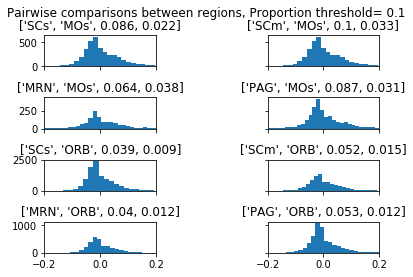

In [163]:
hist_bin = 50

fig, axs = plt.subplots(4, 2, sharex='col', sharey='row',
                        gridspec_kw={'hspace': 1, 'wspace': 1})
(ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8) = axs
fig.suptitle('Pairwise comparisons between regions, Proportion threshold= '+ str(threshold))

# Plot histograms of all region comparisons

ax1.hist(combined_corr_coeff[1], hist_bin)
step = 0
ax1.set_xlim([-0.2,0.2])
ax1.set_title(comparison_pairing[step]+ [proportion_above_threshold[step]]+ [proportion_below_threshold[step]] )

ax2.hist(combined_corr_coeff[1], hist_bin)
step = 1
ax2.set_title(comparison_pairing[step]+ [proportion_above_threshold[step]]+ [proportion_below_threshold[step]] )

ax3.hist(combined_corr_coeff[2], hist_bin)
step = 2
ax3.set_title(comparison_pairing[step]+ [proportion_above_threshold[step]]+ [proportion_below_threshold[step]] )

ax4.hist(combined_corr_coeff[3], hist_bin)
step = 3
ax4.set_xlim([-0.2,0.2])
ax4.set_title(comparison_pairing[step]+ [proportion_above_threshold[step]]+ [proportion_below_threshold[step]] )

ax5.hist(combined_corr_coeff[4], hist_bin)
step = 4
ax5.set_title(comparison_pairing[step]+ [proportion_above_threshold[step]]+ [proportion_below_threshold[step]] )

ax6.hist(combined_corr_coeff[5], hist_bin)
step = 5
ax6.set_xlim()
ax6.set_title(comparison_pairing[step]+ [proportion_above_threshold[step]]+ [proportion_below_threshold[step]] )

ax7.hist(combined_corr_coeff[6], hist_bin)
step = 6
ax7.set_title(comparison_pairing[step]+ [proportion_above_threshold[step]]+ [proportion_below_threshold[step]] )

ax8.hist(combined_corr_coeff[7], hist_bin)
step = 7
ax8.set_title(comparison_pairing[step]+ [proportion_above_threshold[step]]+ [proportion_below_threshold[step]] )


for ax in axs.flat:
    ax.label_outer()


In [ ]:
input_region_a = ['SCs']
input_region_b = ['SCs']
plt.figure(0)
corr_coef = pairwise_corrcoeff(right_spike_time_response, input_region_a,input_region_b)
plt.hist(corr_coef,100)
plt.xlim([-0.2,0.2])
plt.title(input_region_a + input_region_b + [str(find_proportion(corr_coef))] )
plt.ylabel('Frequency')
plt.xlabel('Correlation Coefficient')
plt.show

input_region_a = ['SCs']
input_region_b = ['MOs']
print(np.sum(brain_regions == input_region_a))
plt.figure(1)
corr_coef = pairwise_corrcoeff(right_spike_time_response, input_region_a,input_region_b)
plt.hist(corr_coef,100)
plt.xlim([-0.2,0.2])
plt.title(input_region_a + input_region_b +[str(find_proportion(corr_coef))] )
plt.ylabel('Frequency')
plt.xlabel('Correlation Coefficient')
plt.show

In [ ]:
# Perform some quick visualisation on the spike and behaviour data

plt.figure(0)
cell_num = 42
plt.plot(midbrain_concat_left_spike_times[cell_num])
plt.title('Spikes for 1 cell across session (10ms bin)')
plt.show

plt.figure(1)
plt.plot(left_concat_wheel_position)
plt.title('Wheel position across session')
plt.show



In [ ]:
# Perform regression analysis

corr_coeff = np.array([])
for cell_num in np.arange(len(midbrain_concat_left_spike_times)):
    corr_coeff = np.append(corr_coeff,np.corrcoef(midbrain_concat_left_spike_times[cell_num], left_concat_wheel_position)[0,1])

plt.figure(0)
plt.hist(corr_coeff,bins = 20)
plt.title('Midbrain Correlation Coeff with Wheel')
plt.xlim((-0.08, 0.08))
plt.show

corr_coeff = np.array([])
for cell_num in np.arange(len(forebrain_concat_left_spike_times)):
    corr_coeff = np.append(corr_coeff,np.corrcoef(forebrain_concat_left_spike_times[cell_num], left_concat_wheel_position)[0,1])

plt.figure(1)
plt.hist(corr_coeff,bins = 20)
plt.title('Forebrain Correlation Coeff with Wheel')
plt.xlim((-0.08, 0.08))
plt.show

corr_coeff = np.array([])
for cell_num in np.arange(len(forebrain_concat_left_spike_times)):
    corr_coeff = np.append(corr_coeff,np.corrcoef(forebrain_concat_left_spike_times[cell_num], left_concat_wheel_position)[0,1])

plt.figure(1)
plt.hist(corr_coeff,bins = 20)
plt.title('Forebrain Correlation Coeff with Wheel')
plt.xlim((-0.08, 0.08))
plt.show

